0. **[Stuff](#0.-Stuff)**<br>
    0.1 [About the notebook](#0.1-About-the-notebook)<br>
    0.2 [Imports](#0.2-Imports)<br>
    0.3 [Definitions](#0.3-Definitions)<br>
    0.4 [Functions](#0.4-Functions)<br>
1. **[Derive quantities](#1.-Derive-quantities)**<br>
2. **[x-y histograms](#2.-x-y-histograms)**<br>
    2.1 [first assumption](#2.1-first-assumption)<br>
    2.2 [second assumption](#2.2-second-assumption)<br>
    2.3 [third assumption](#2.3-third-assumption)<br>
    2.4 [fourth assumption](#2.4-fourth-assumption)<br>
3. **[x-y scatter plot](#3.-x-y-scatter-plot)**<br>
4. **[Investigate electrostatic sagging](#4.-Investigate-electrostatic-sagging)**<br>

# 0. Stuff

## 0.1 About the notebook

In [ ]:
### This notebook is meant to analysis the s2 r-dependency caused by electrostatic sagging of the anode ### 

### It returns the corrected s2, x,y,z under 4 assumptions:
###      - single scatter cut, fiducial-z cut
###      - single scatter cut, fiducial-z cut, fiducial-r cut 
###      - single scatter cut, fiducial-z cut, top PMT > 0 cut
###      - single scatter cut, fiducial-z cut, top PMT > 0 cut, fiducial-r cut

## 0.2 Imports

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import straxbra
from matplotlib.ticker import AutoMinorLocator
from matplotlib.image import NonUniformImage
import pandas as pd
import patrick_stylez as ps
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import chi2 

Using TensorFlow backend.


## 0.3 Definitions

In [66]:
ctx = straxbra.XebraContext()
run = '00158'
peaks_data = ctx.get_array(run, 'peaks')
position_data = ctx.get_array(run, 'peak_positions')
waveform = peaks_data['data']
integral = peaks_data['area']
width = peaks_data['width'][:,5]
timestamp = peaks_data['time']
risetime = -peaks_data['area_decile_from_midpoint'][:,1]
area_per_channel = peaks_data['area_per_channel']
x_position = position_data['x']
y_position = position_data['y']

## 0.4 Functions

In [67]:
def CutCondition(waveform):  
    FirstPeak_area = sum(waveform[:15])
    SecondPeak_area = sum(waveform[15:])
    FirstPeak_maximum = max(waveform[:15])
    SecondPeak_maximum = max(waveform[15:])
    SecondPeak_index = np.where(waveform == SecondPeak_maximum)
    SecondPeak_index_left = SecondPeak_index[0][0] -1
    SecondPeak_index_right = SecondPeak_index[0][0] +1
    SecondPeak_maximum_left = waveform[SecondPeak_index_left]
    SecondPeak_maximum_right = waveform[SecondPeak_index_right]



    if  FirstPeak_area > 100 and FirstPeak_area < 500 and SecondPeak_area > 40 and SecondPeak_area  < 200 \
    and SecondPeak_maximum < 0.5 * FirstPeak_maximum \
    and SecondPeak_maximum > 0.25 * FirstPeak_maximum \
    and SecondPeak_maximum > waveform[SecondPeak_index_left] \
    and SecondPeak_maximum > waveform[SecondPeak_index_right] \
    : 
        return(True)
    else:
        return(False)
    
def S2_found(integral, width):
    #maximum_S2 = max(waveform)
    if integral > 500 and width >200 and width < 2000:
        return True
    else:
        return False

def log_gaus(x, h, mu, sigma):

    log_gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
    return log_gaus

def expo(x, a, b):
    return a*np.exp(-b*x)

def drifttime_to_z(t,ai, bi):
    return ai * t + bi

def poisson_interval(k, alpha=0.318):
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0:
        low = 0.0
    low_interval = k - low
    high_interval = high - k
    return low_interval, high_interval

def Process(waveform,i,drifttime_list, s2_list, aii, bii, timestamp): 
    SelectionCutFlag = CutCondition(waveform[i])
    if SelectionCutFlag == True:
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if S2_found(integral = integral[i+j], width = width[i+j]):
                k=1 
                s2_counter_timestamp = timestamp[i+j+k]
                z_position = drifttime_to_z(t=(timestamp[i+j] - timestamp[i]), ai=aii, bi=bii)
                while threshold_timestamp >= s2_counter_timestamp and S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:

                    if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5 and integral[i+j] < 50000:
                        time       = timestamp[i+j] - timestamp[i]
                        drifttime.append(time)
                        s2.append(integral[i+j])
                        return
                    else:
                        return
                return
            else:
                return
    else:
        return
    
    
def Process_corrected(waveform,i, corrected_s2, aii, bii, timestamp,electron_lifetime): 
    SelectionCutFlag = CutCondition(waveform[i])
    if SelectionCutFlag == True:

        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if S2_found(integral = integral[i+j], width = width[i+j]):

                k=1 
                s2_counter_timestamp = timestamp[i+j+k]
                z_position = drifttime_to_z(t=(timestamp[i+j] - timestamp[i]), ai=aii, bi=bii)
                while threshold_timestamp >= s2_counter_timestamp and S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:


                    if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5 and integral[i+j] < 50000:

                        ctime       = timestamp[i+j] - timestamp[i]
                        S2 = integral[i+j]
                        s2_corrected = S2/(np.exp(-ctime/(electron_lifetime*1e3)))
                        cs2_raw.append(s2_corrected)
                        r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)
                        r_raw.append(r_position)
                        x_raw.append(x_position[i+j])
                        y_raw.append(y_position[i+j])
                        if r_position <= fiducial_r:
                            r.append(r_position)
                            x.append(x_position[i+j])
                            y.append(y_position[i+j])
                            cs2.append(s2_corrected)


                        if area_per_channel[i+j][1] > 0 and area_per_channel[i+j][2] > 0 \
                            and area_per_channel[i+j][3] > 0 and area_per_channel[i+j][4] > 0 \
                            and area_per_channel[i+j][5] > 0 and area_per_channel[i+j][6] > 0 \
                            and area_per_channel[i+j][7] > 0 \
                            :
                            r_cut_raw.append(r_position)
                            x_cut_raw.append(x_position[i+j])
                            y_cut_raw.append(y_position[i+j])
                            cs2_cut_raw.append(s2_corrected)
                            
                            if r_position <= fiducial_r:
                                r_cut.append(r_position)
                                x_cut.append(x_position[i+j])
                                y_cut.append(y_position[i+j])
                                cs2_cut.append(s2_corrected)
                                
                                return
                            else:
                                return   
                            return
                        else:
                            return
                        
                        return
                    else:
                        return
                return
            else:
                return
        return
    else:
        return
    
def compute_lifetime(s2,drifttime):
    
    bins_x = np.linspace(0,50,40)
    bins_y = np.logspace(2,5,40) 
    drifttime = np.array(drifttime)
    counts, xedges, yedges = np.histogram2d(drifttime/1e3, s2, bins=(bins_x, bins_y))
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    poisson_list = []
    for i in counts:
        error_per_slice = []
        for j in i:
            q =poisson_interval(j)[1]
            error_per_slice.append(q)
        poisson_list.append(error_per_slice)
        
    fit_range= np.linspace(1000,30000,1000)

    

    p0 = [50,8,2]

    expectation_list = []
    error_list = []
    for i in range(5,30):   
        popt, pcov = curve_fit(log_gaus, ycenter, counts[i], p0= p0, sigma = poisson_list[i], absolute_sigma = True)
        perr = np.sqrt(np.diag(pcov))

        expectation = np.exp(popt[1]+((popt[2]**2)/2))
        expectation_list.append(expectation)

    
        diff_mu = expectation
        diff_sigma = expectation*popt[2]
        error_mu = perr[1]
        error_sigma = perr[2]
    
        error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
        error_list.append(error)
    
 
    p1=  [10000,0.1]
    x = np.linspace(5,30,25)
    popt, pcov = curve_fit(expo, x, expectation_list, sigma=error_list, p0=p1, absolute_sigma=True, maxfev= 10000)
    perr = np.sqrt(np.diag(pcov))
    lifetime =(1/popt[1])
    lifetime_error =(1/(popt[1]**2))*perr[1]
    print('electron lifetime: ', lifetime, '+/-', lifetime_error)
    
    return (lifetime, lifetime_error)






# 1. Derive quantities

In [68]:
left_edge  = [0, 0]
right_edge = [40500.0, -71.5]
a = ((right_edge[1])-(left_edge[1])) / ((right_edge[0])-(left_edge[0]))
b = (right_edge[1]) - a * (right_edge[0])
fiducial_r = 23
s2 = []
drifttime = []
cs2_raw = []
cs2 = []
cs2_cut_raw = []
cs2_cut = []
x = []
y = []
r = []
x_raw = []
y_raw = []
r_raw = []

r_cut_raw = []
x_cut_raw = []
y_cut_raw = []
r_cut = []
x_cut = []
y_cut = []

In [69]:
num = len(waveform)
print_counter = 0.0
for i in range(0,num-10):    
    Process(waveform,i,drifttime_list = drifttime, s2_list = s2, aii=a, bii=b, timestamp=timestamp)
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
print(1.0, '        Run ',run, 'done!')

0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00158 done!


In [70]:
electron_lifetime, lifetime_error = compute_lifetime(s2,drifttime)    

electron lifetime:  601.8108223803716 +/- 138.12820985109062


In [71]:
print_counter = 0.0
for i in range(0,num-10):    
    Process_corrected(waveform,i,corrected_s2 = cs2_raw, aii=a, bii=b, timestamp=timestamp, electron_lifetime = electron_lifetime)
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
print(1.0, '        Run ',run, 'done!')

0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00158 done!


In [72]:
print(len(r_raw))
print(len(r))
print(len(r_cut_raw))
print(len(r_cut))

13485
5193
9538
4497


# 2. x-y histograms

## 2.1 first assumption

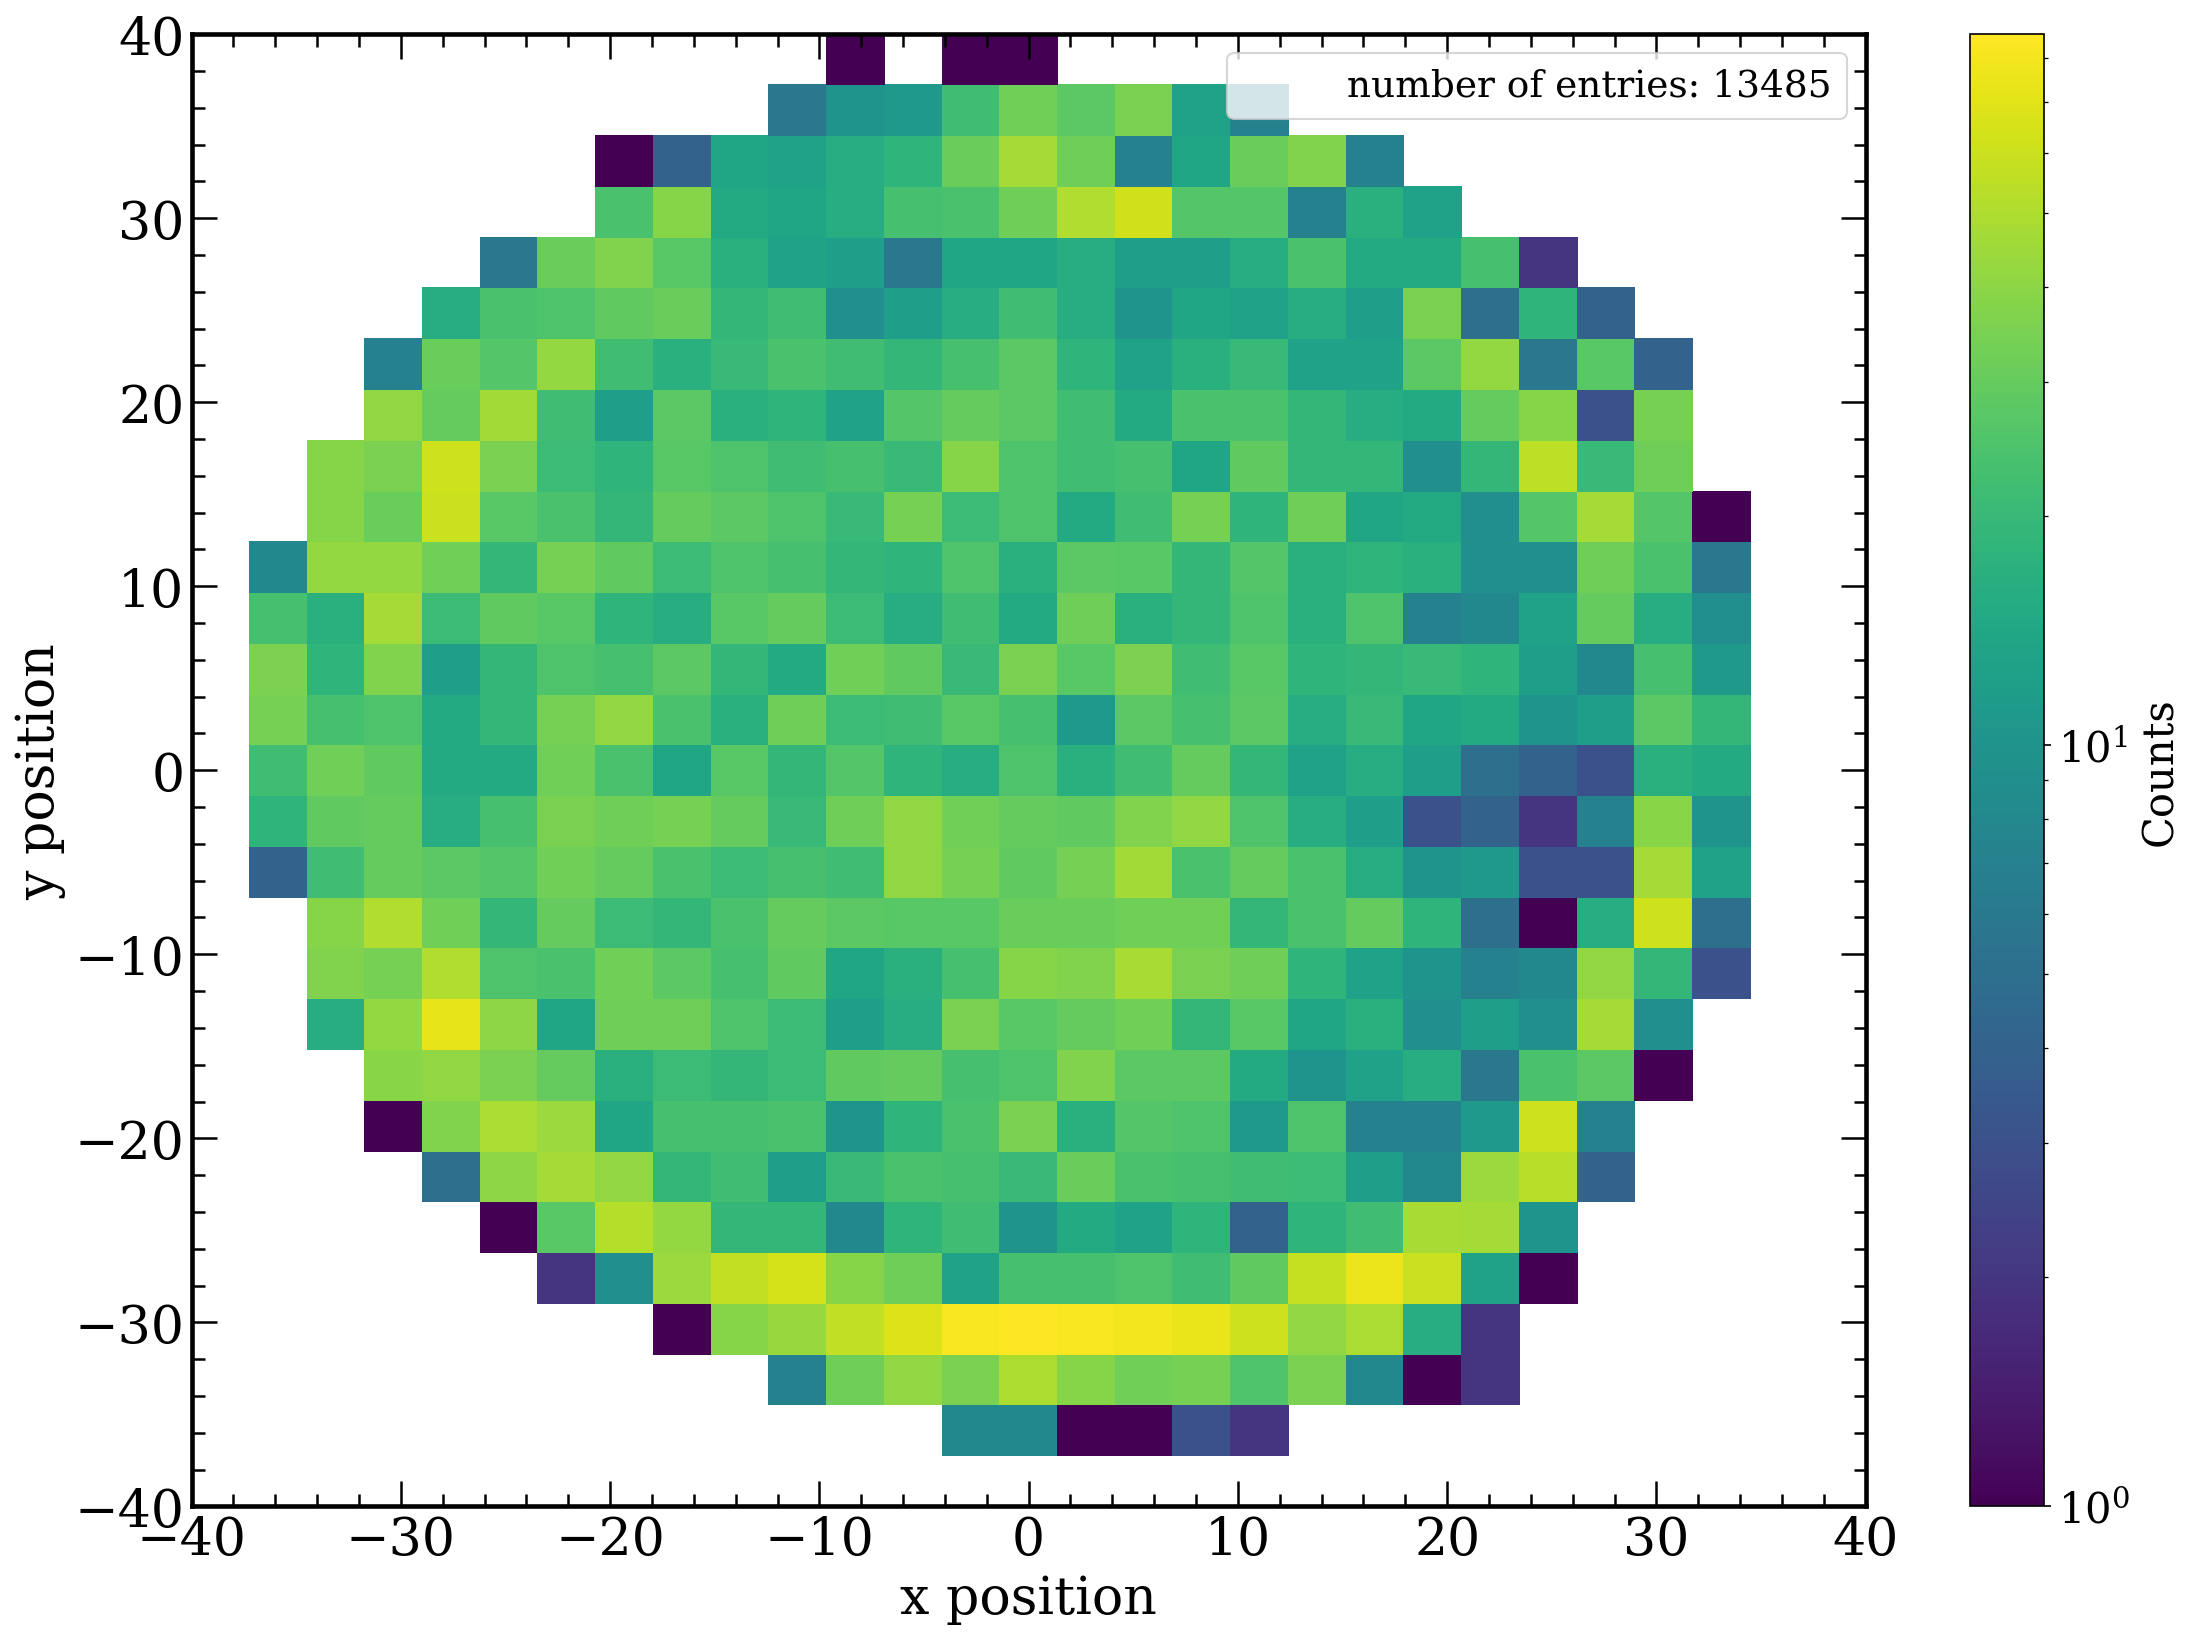

In [86]:
fig, axes = ps.styles()
bins_x = np.linspace(-40,40,30)
bins_y = np.linspace(-40,40,30)
counts, _, _ = np.histogram2d(x_raw,y_raw, bins=(bins_x, bins_y))
im = axes.pcolormesh(bins_x, bins_y, counts.T, norm=mpl.colors.LogNorm(), cmap = 'viridis')
cb = plt.colorbar(im, ax=axes, label='Counts')
cb.set_label('Counts',size=20)
cb.ax.tick_params(labelsize=20)
axes.plot([], [], ' ', label="number of entries: "+str(len(x_raw)))
axes.set_xlabel('x position')
axes.set_ylabel('y position')
axes.legend(prop={'size': 18})
plt.show()

## 2.2 second assumption

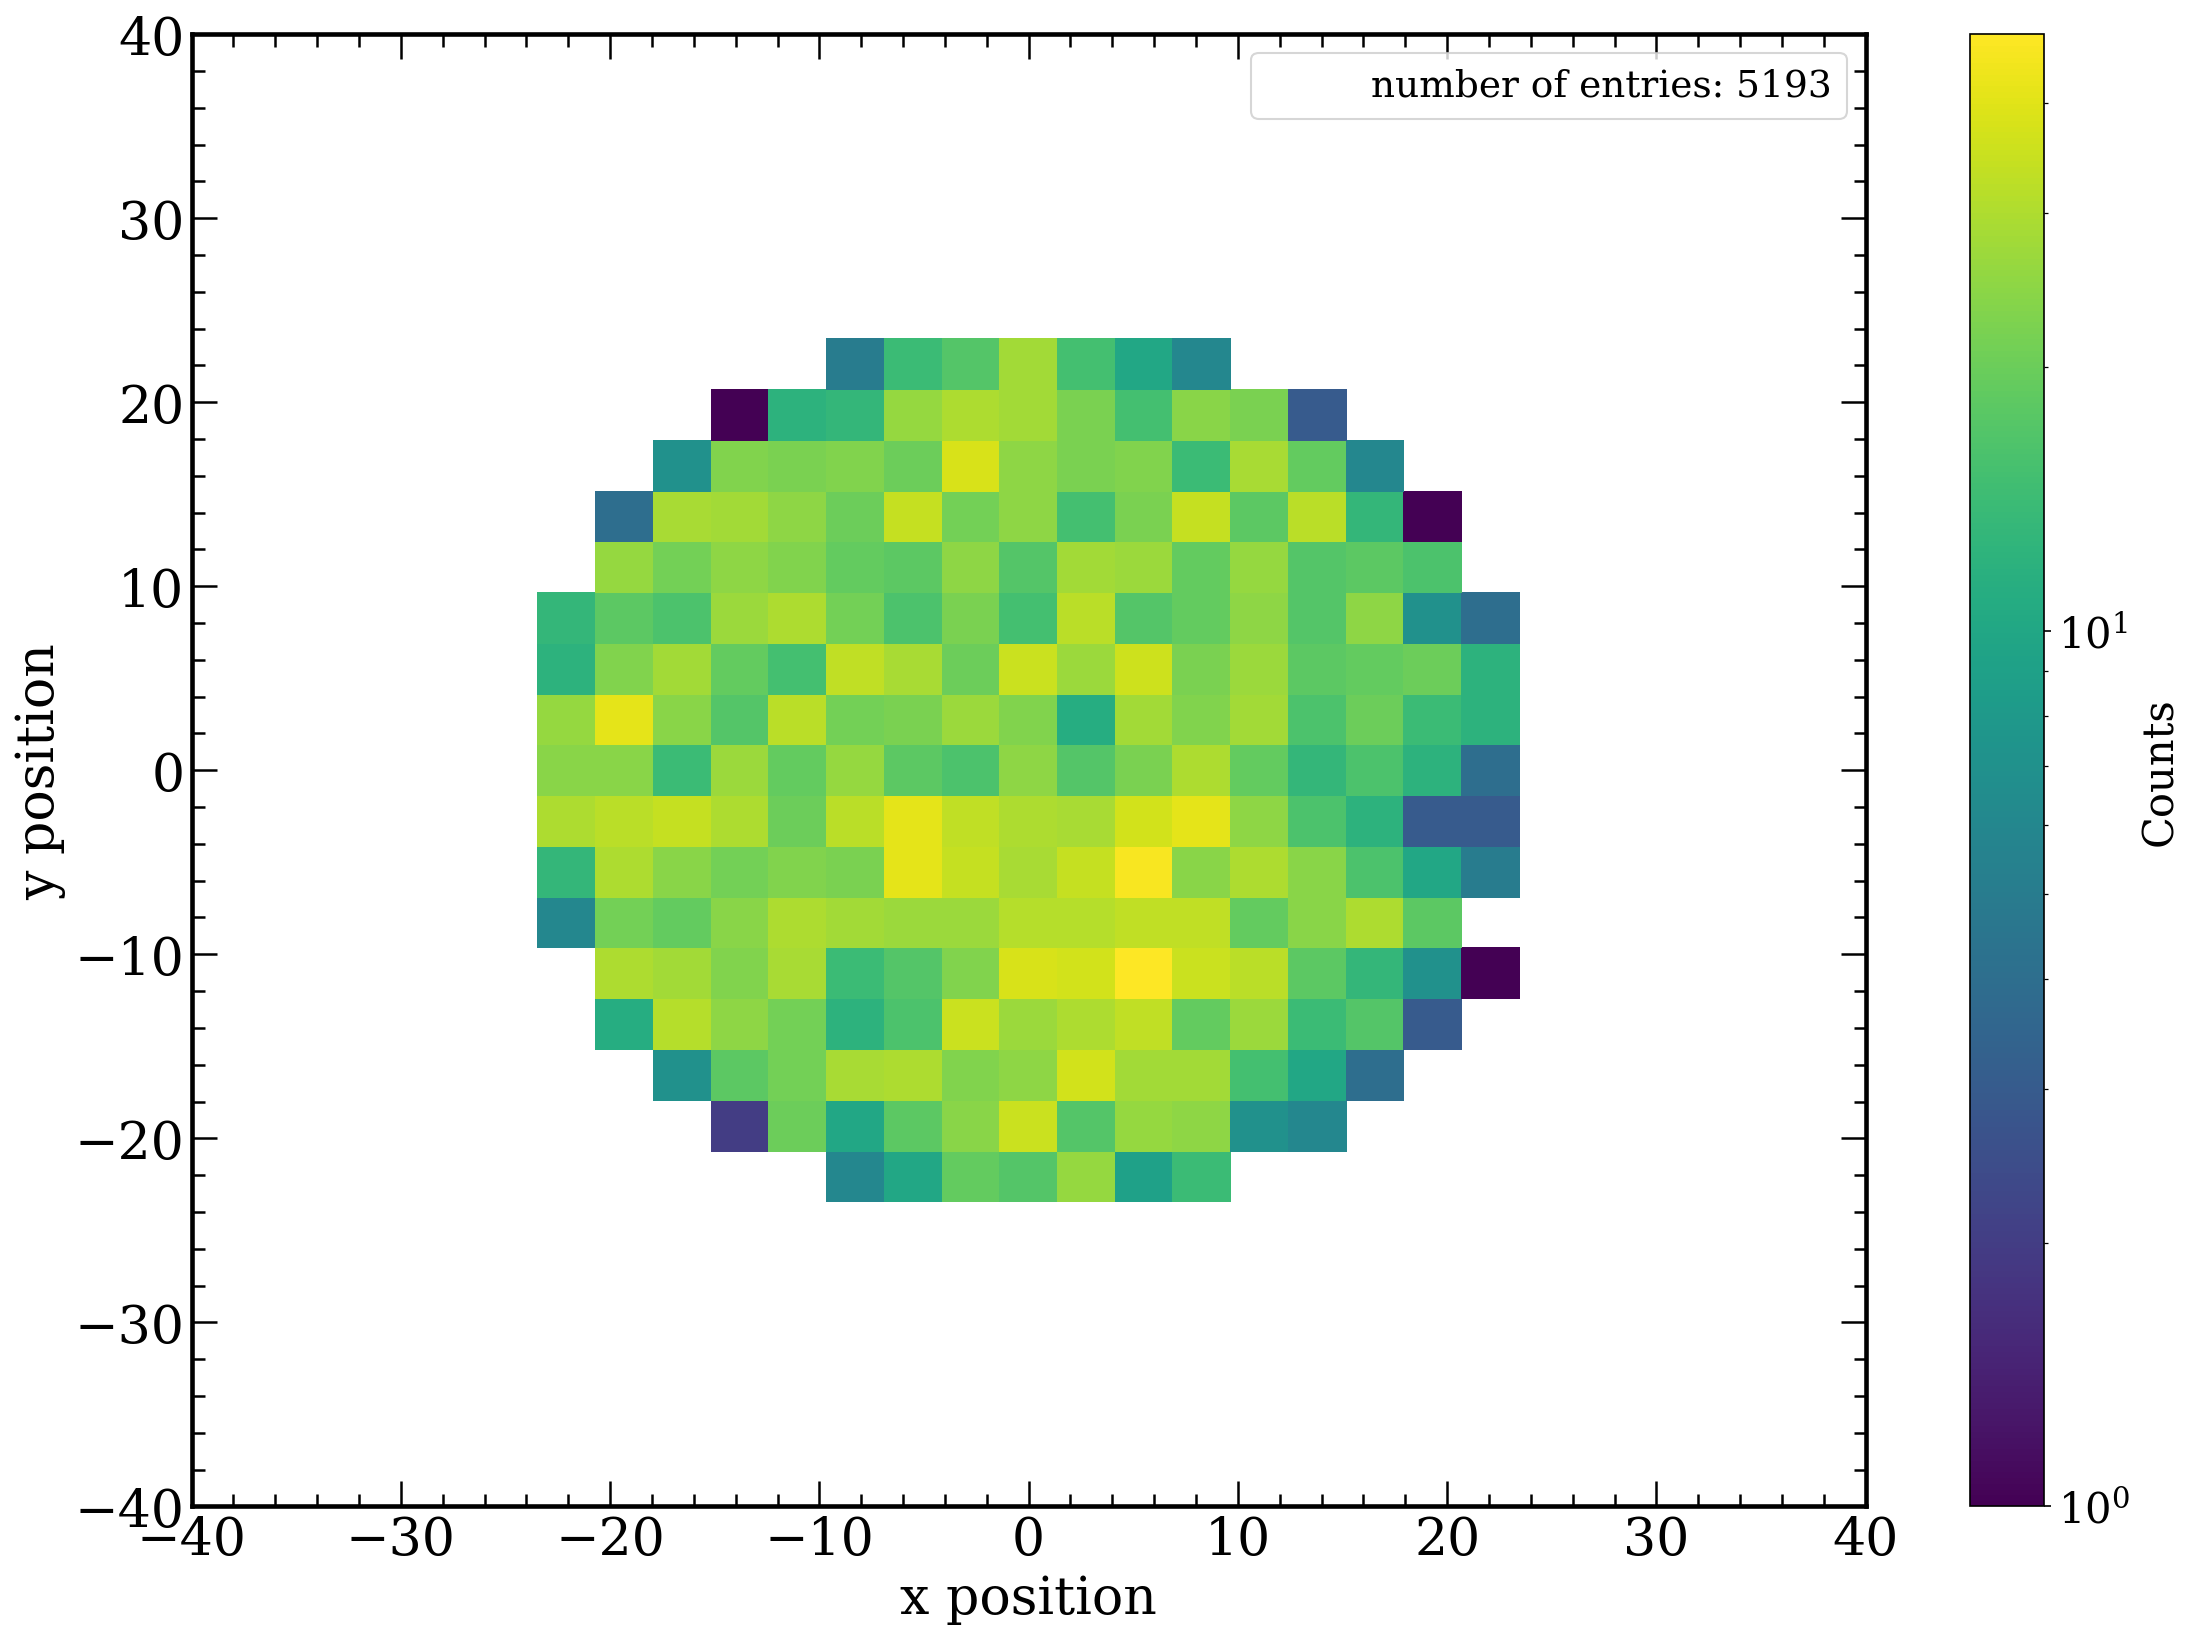

In [87]:
fig, axes = ps.styles()
bins_x = np.linspace(-40,40,30)
bins_y = np.linspace(-40,40,30)
counts, _, _ = np.histogram2d(x,y, bins=(bins_x, bins_y))
im = axes.pcolormesh(bins_x, bins_y, counts.T, norm=mpl.colors.LogNorm(), cmap = 'viridis')
cb = plt.colorbar(im, ax=axes, label='Counts')
cb.set_label('Counts',size=20)
cb.ax.tick_params(labelsize=20)
axes.plot([], [], ' ', label="number of entries: "+str(len(x)))
axes.set_xlabel('x position')
axes.set_ylabel('y position')
axes.legend(prop={'size': 18})
plt.show()

## 2.3 third assumption

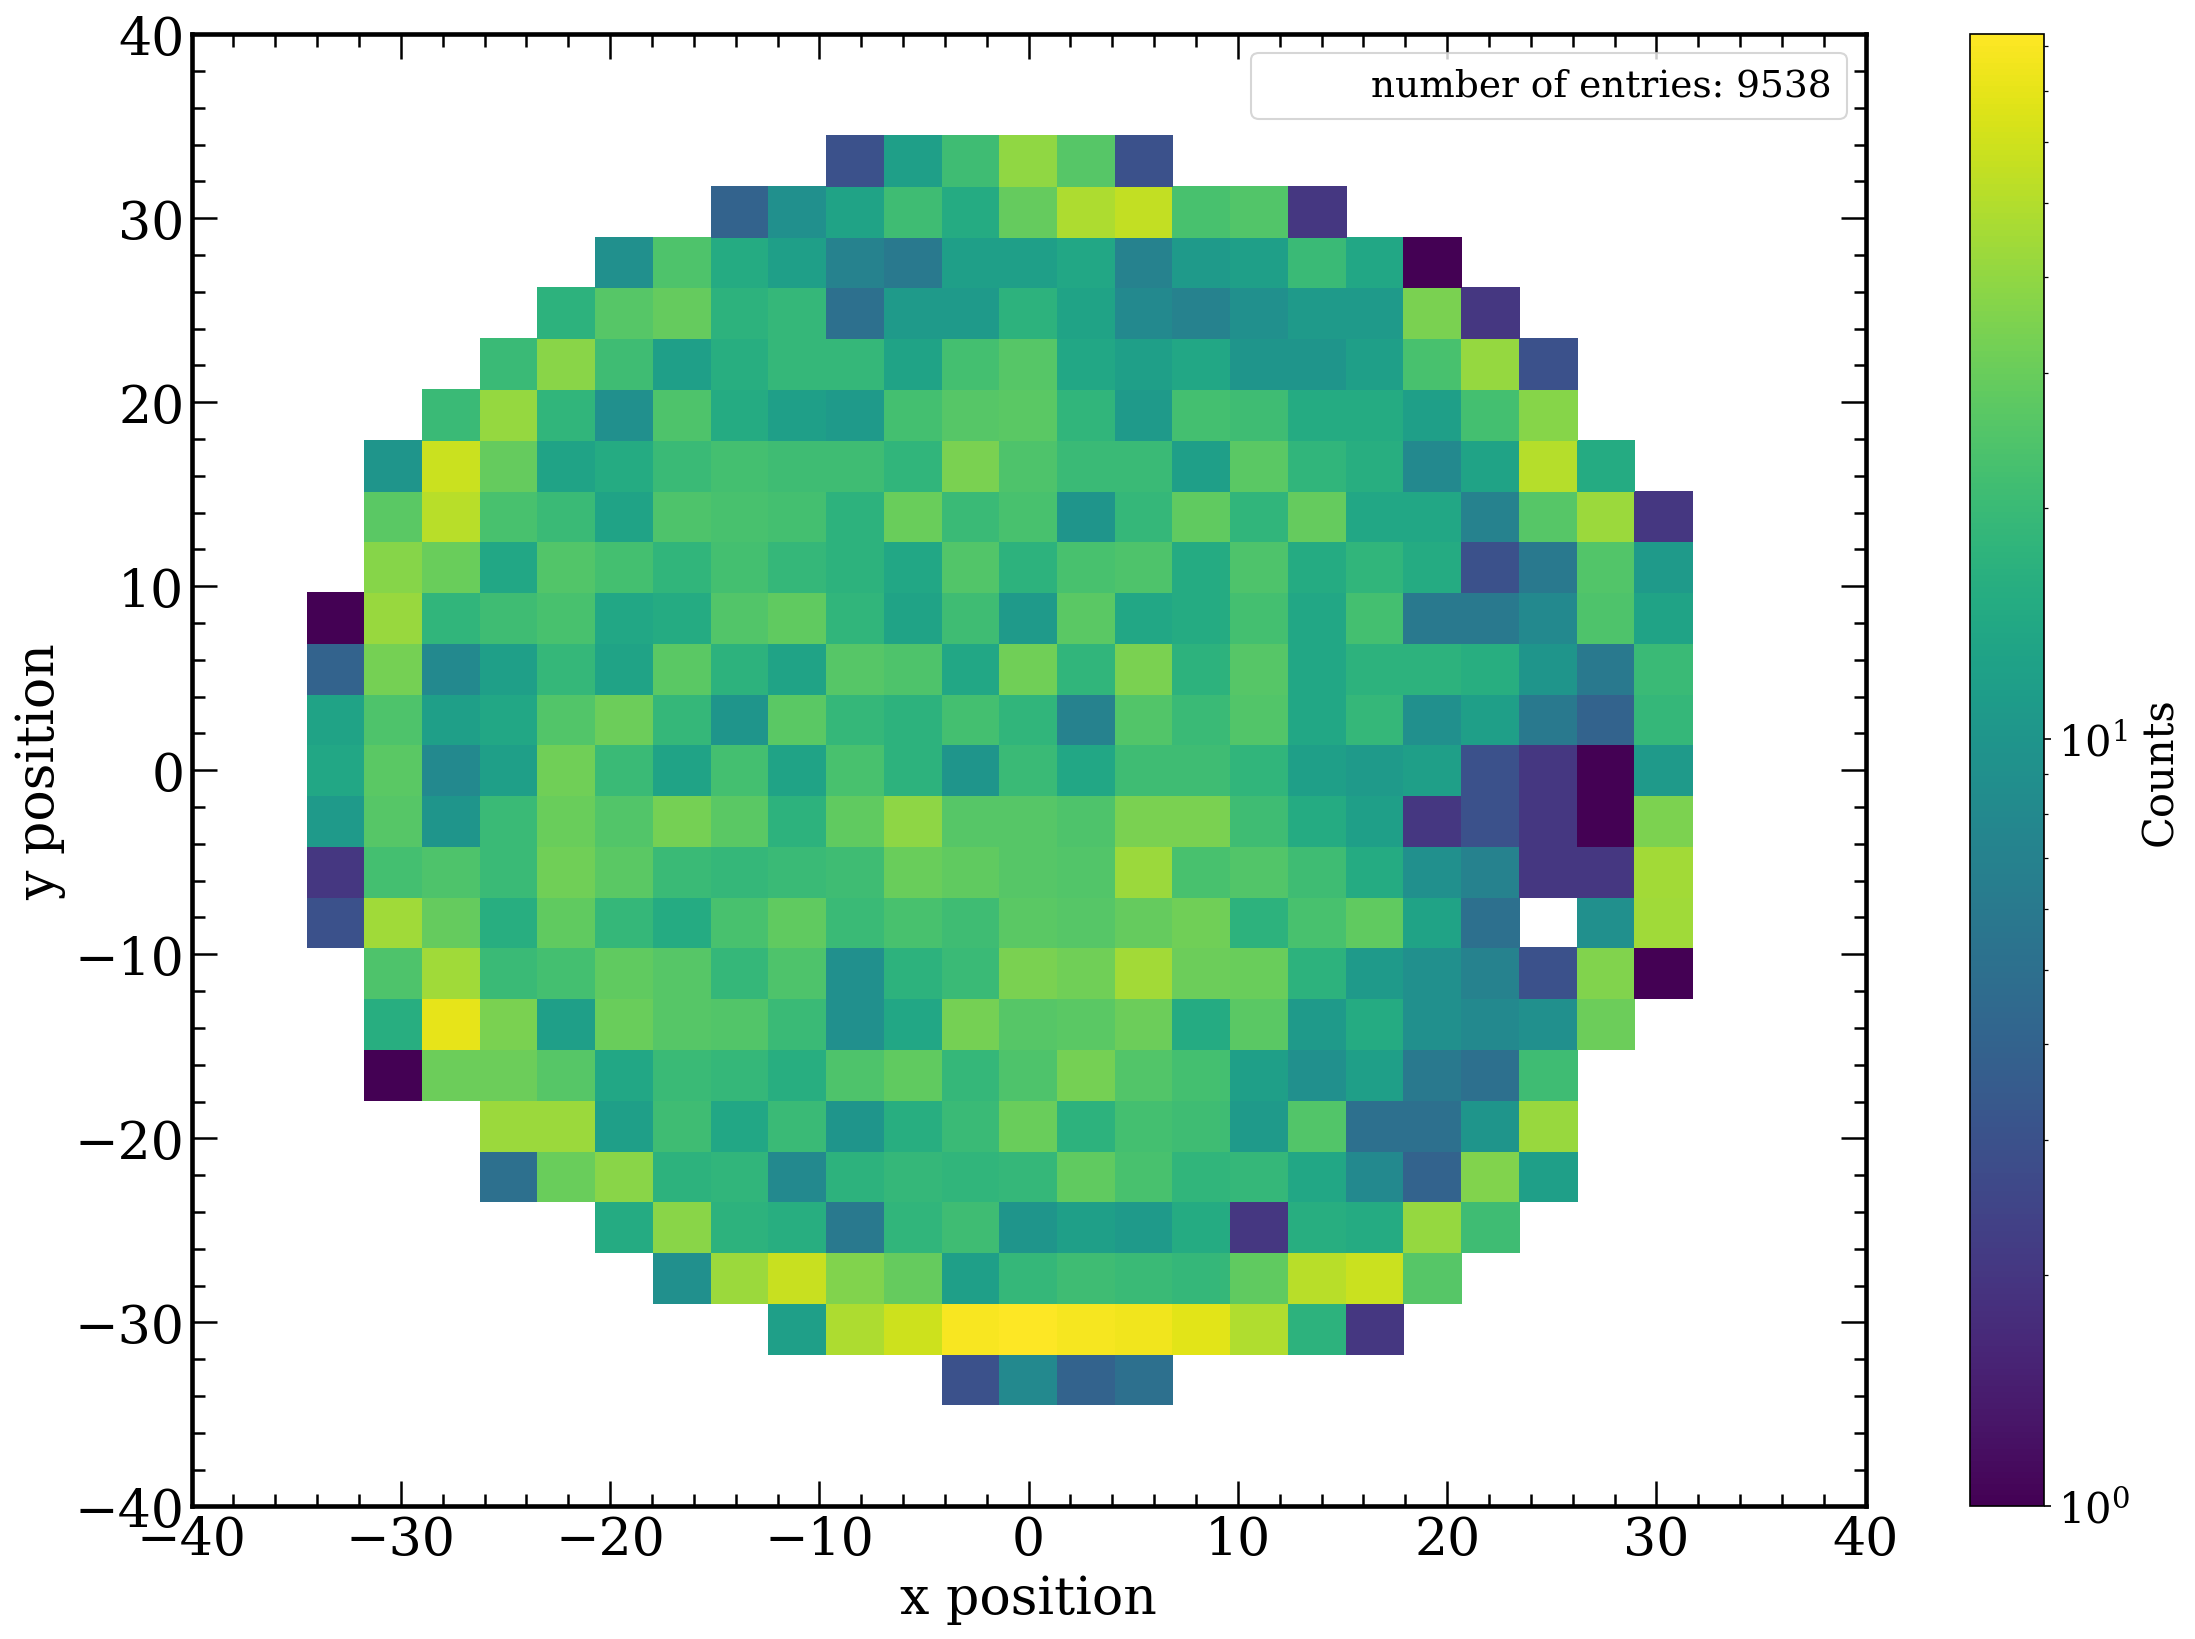

In [88]:
fig, axes = ps.styles()
bins_x = np.linspace(-40,40,30)
bins_y = np.linspace(-40,40,30)
counts, _, _ = np.histogram2d(x_cut_raw,y_cut_raw, bins=(bins_x, bins_y))
im = axes.pcolormesh(bins_x, bins_y, counts.T, norm=mpl.colors.LogNorm(), cmap = 'viridis')
cb = plt.colorbar(im, ax=axes, label='Counts')
cb.set_label('Counts',size=20)
cb.ax.tick_params(labelsize=20)
axes.plot([], [], ' ', label="number of entries: "+str(len(x_cut_raw)))
axes.set_xlabel('x position')
axes.set_ylabel('y position')
axes.legend(prop={'size': 18})
plt.show()

## 2.4 fourth assumption

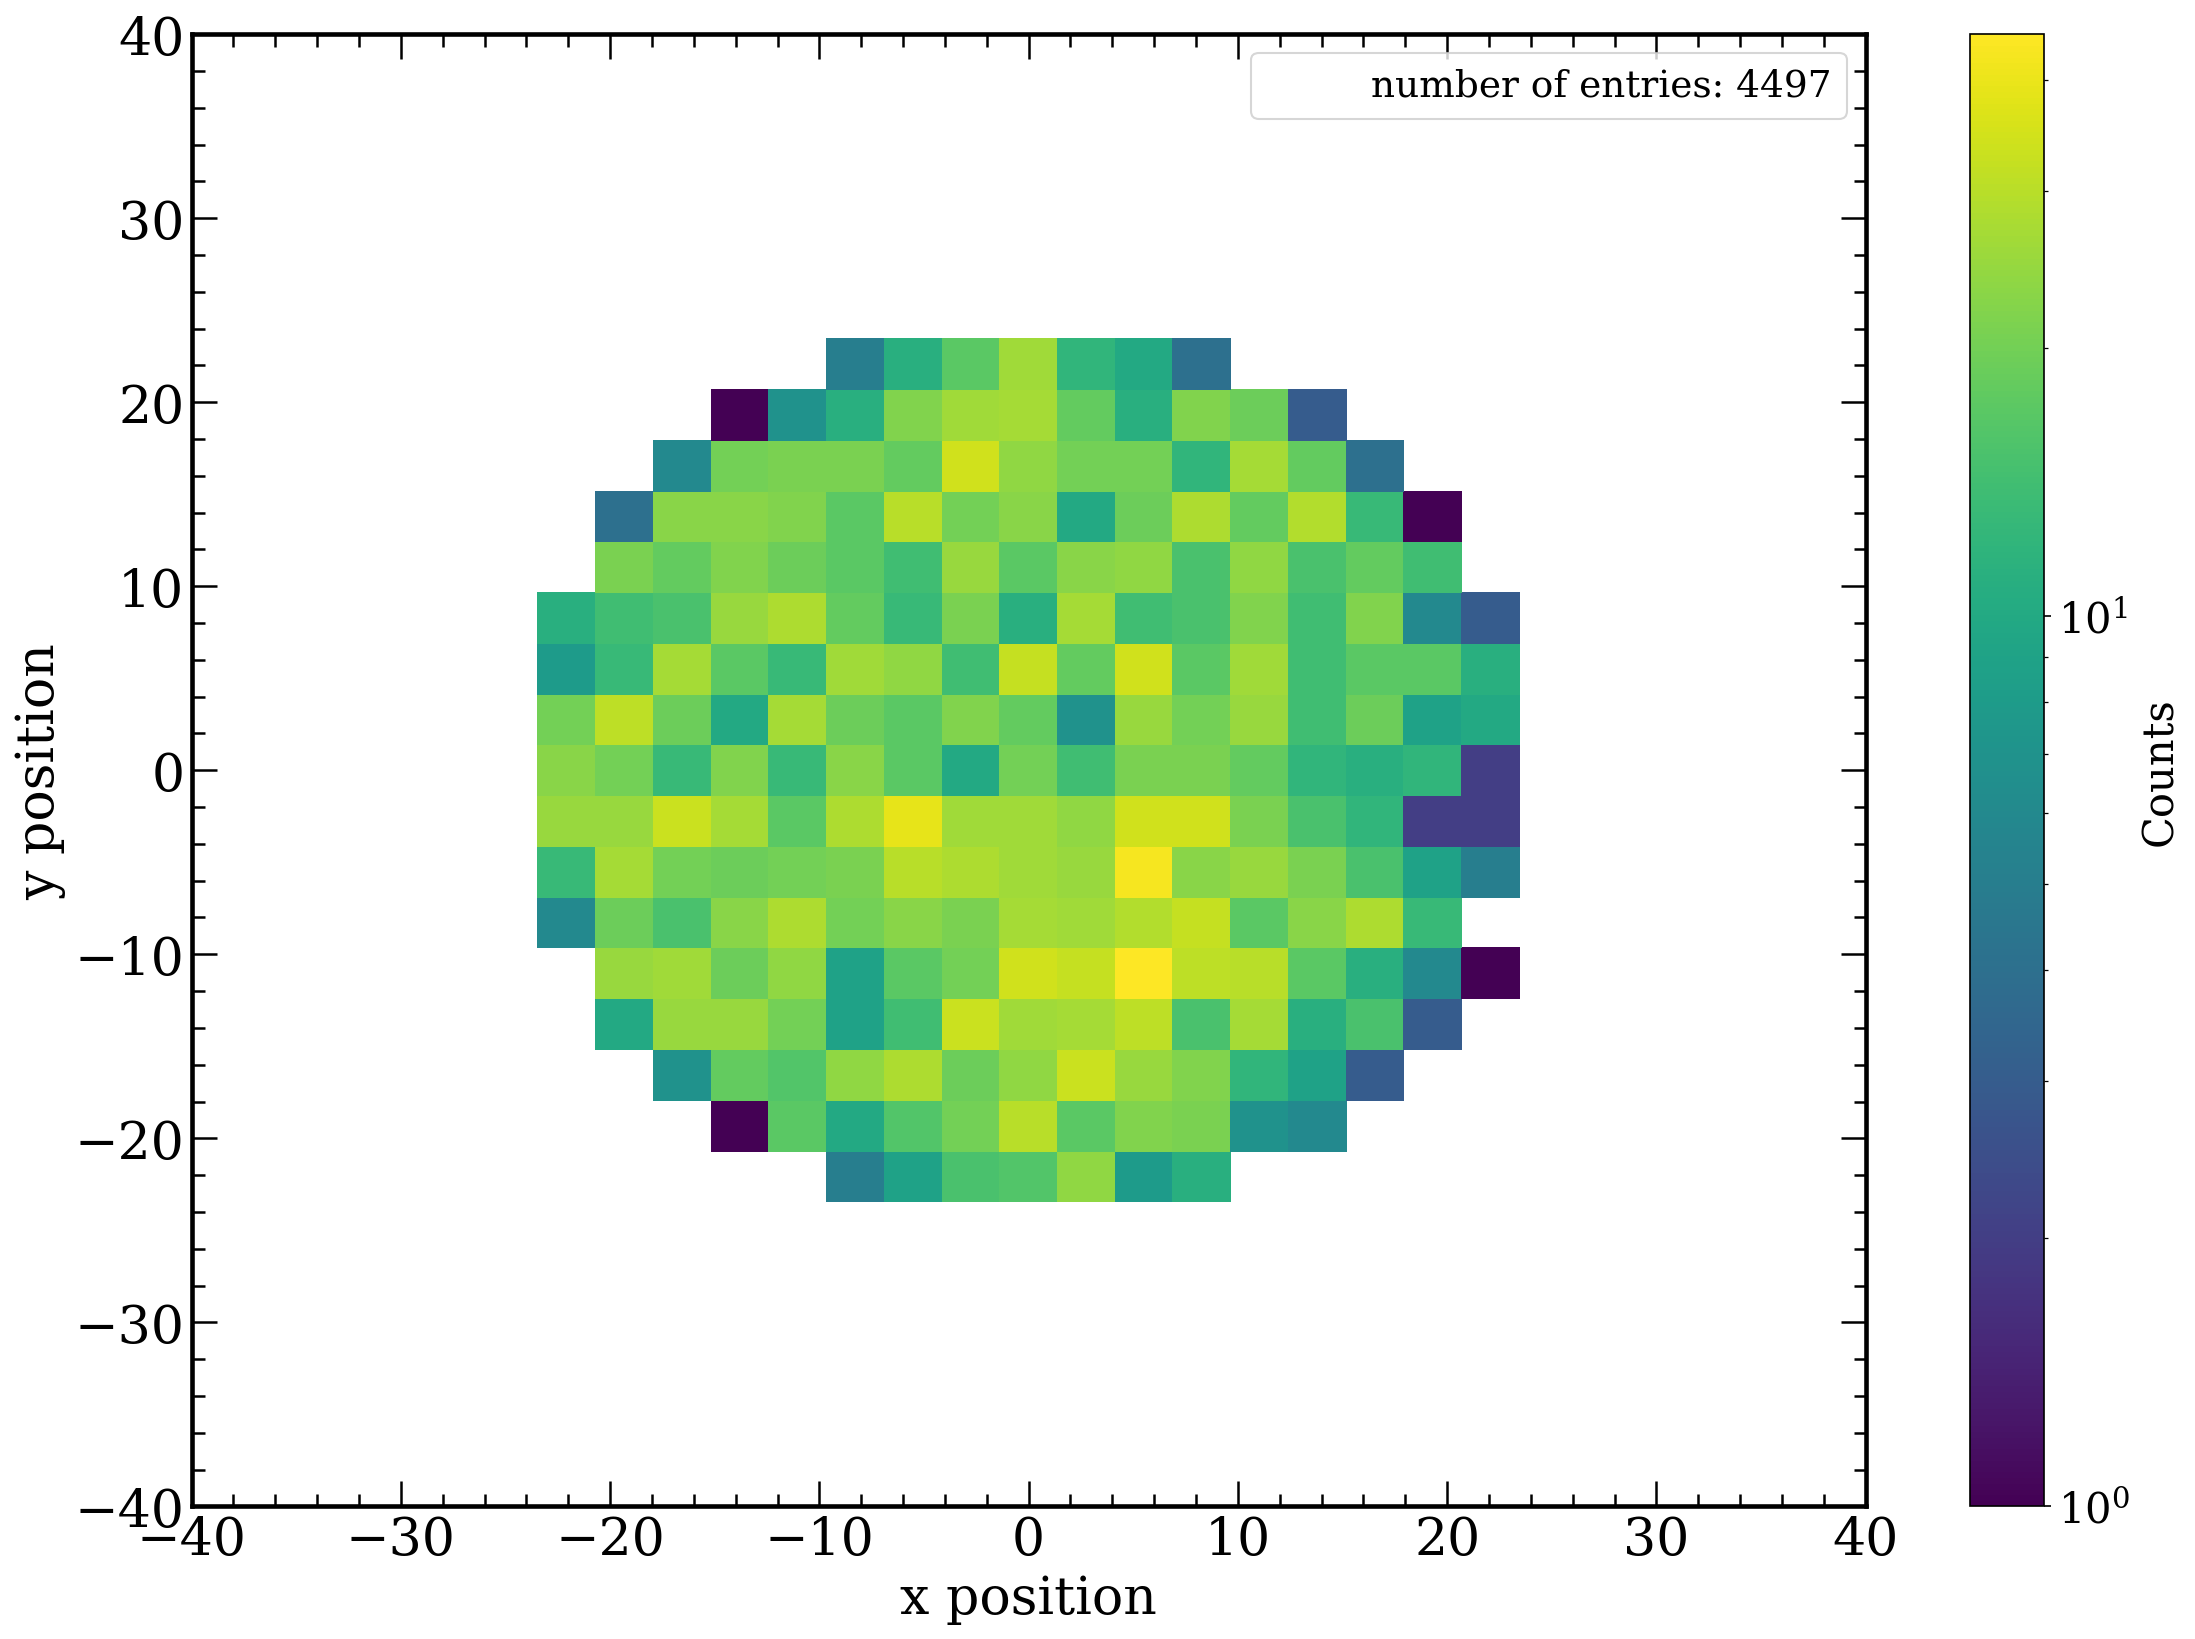

In [89]:
fig, axes = ps.styles()
bins_x = np.linspace(-40,40,30)
bins_y = np.linspace(-40,40,30)
counts, _, _ = np.histogram2d(x_cut,y_cut, bins=(bins_x, bins_y))
im = axes.pcolormesh(bins_x, bins_y, counts.T, norm=mpl.colors.LogNorm(), cmap = 'viridis')
cb = plt.colorbar(im, ax=axes, label='Counts')
cb.set_label('Counts',size=20)
cb.ax.tick_params(labelsize=20)
axes.plot([], [], ' ', label="number of entries: "+str(len(x_cut)))
axes.set_xlabel('x position')
axes.set_ylabel('y position')
axes.legend(prop={'size': 18})
plt.show()

# 3. x-y scatter plot

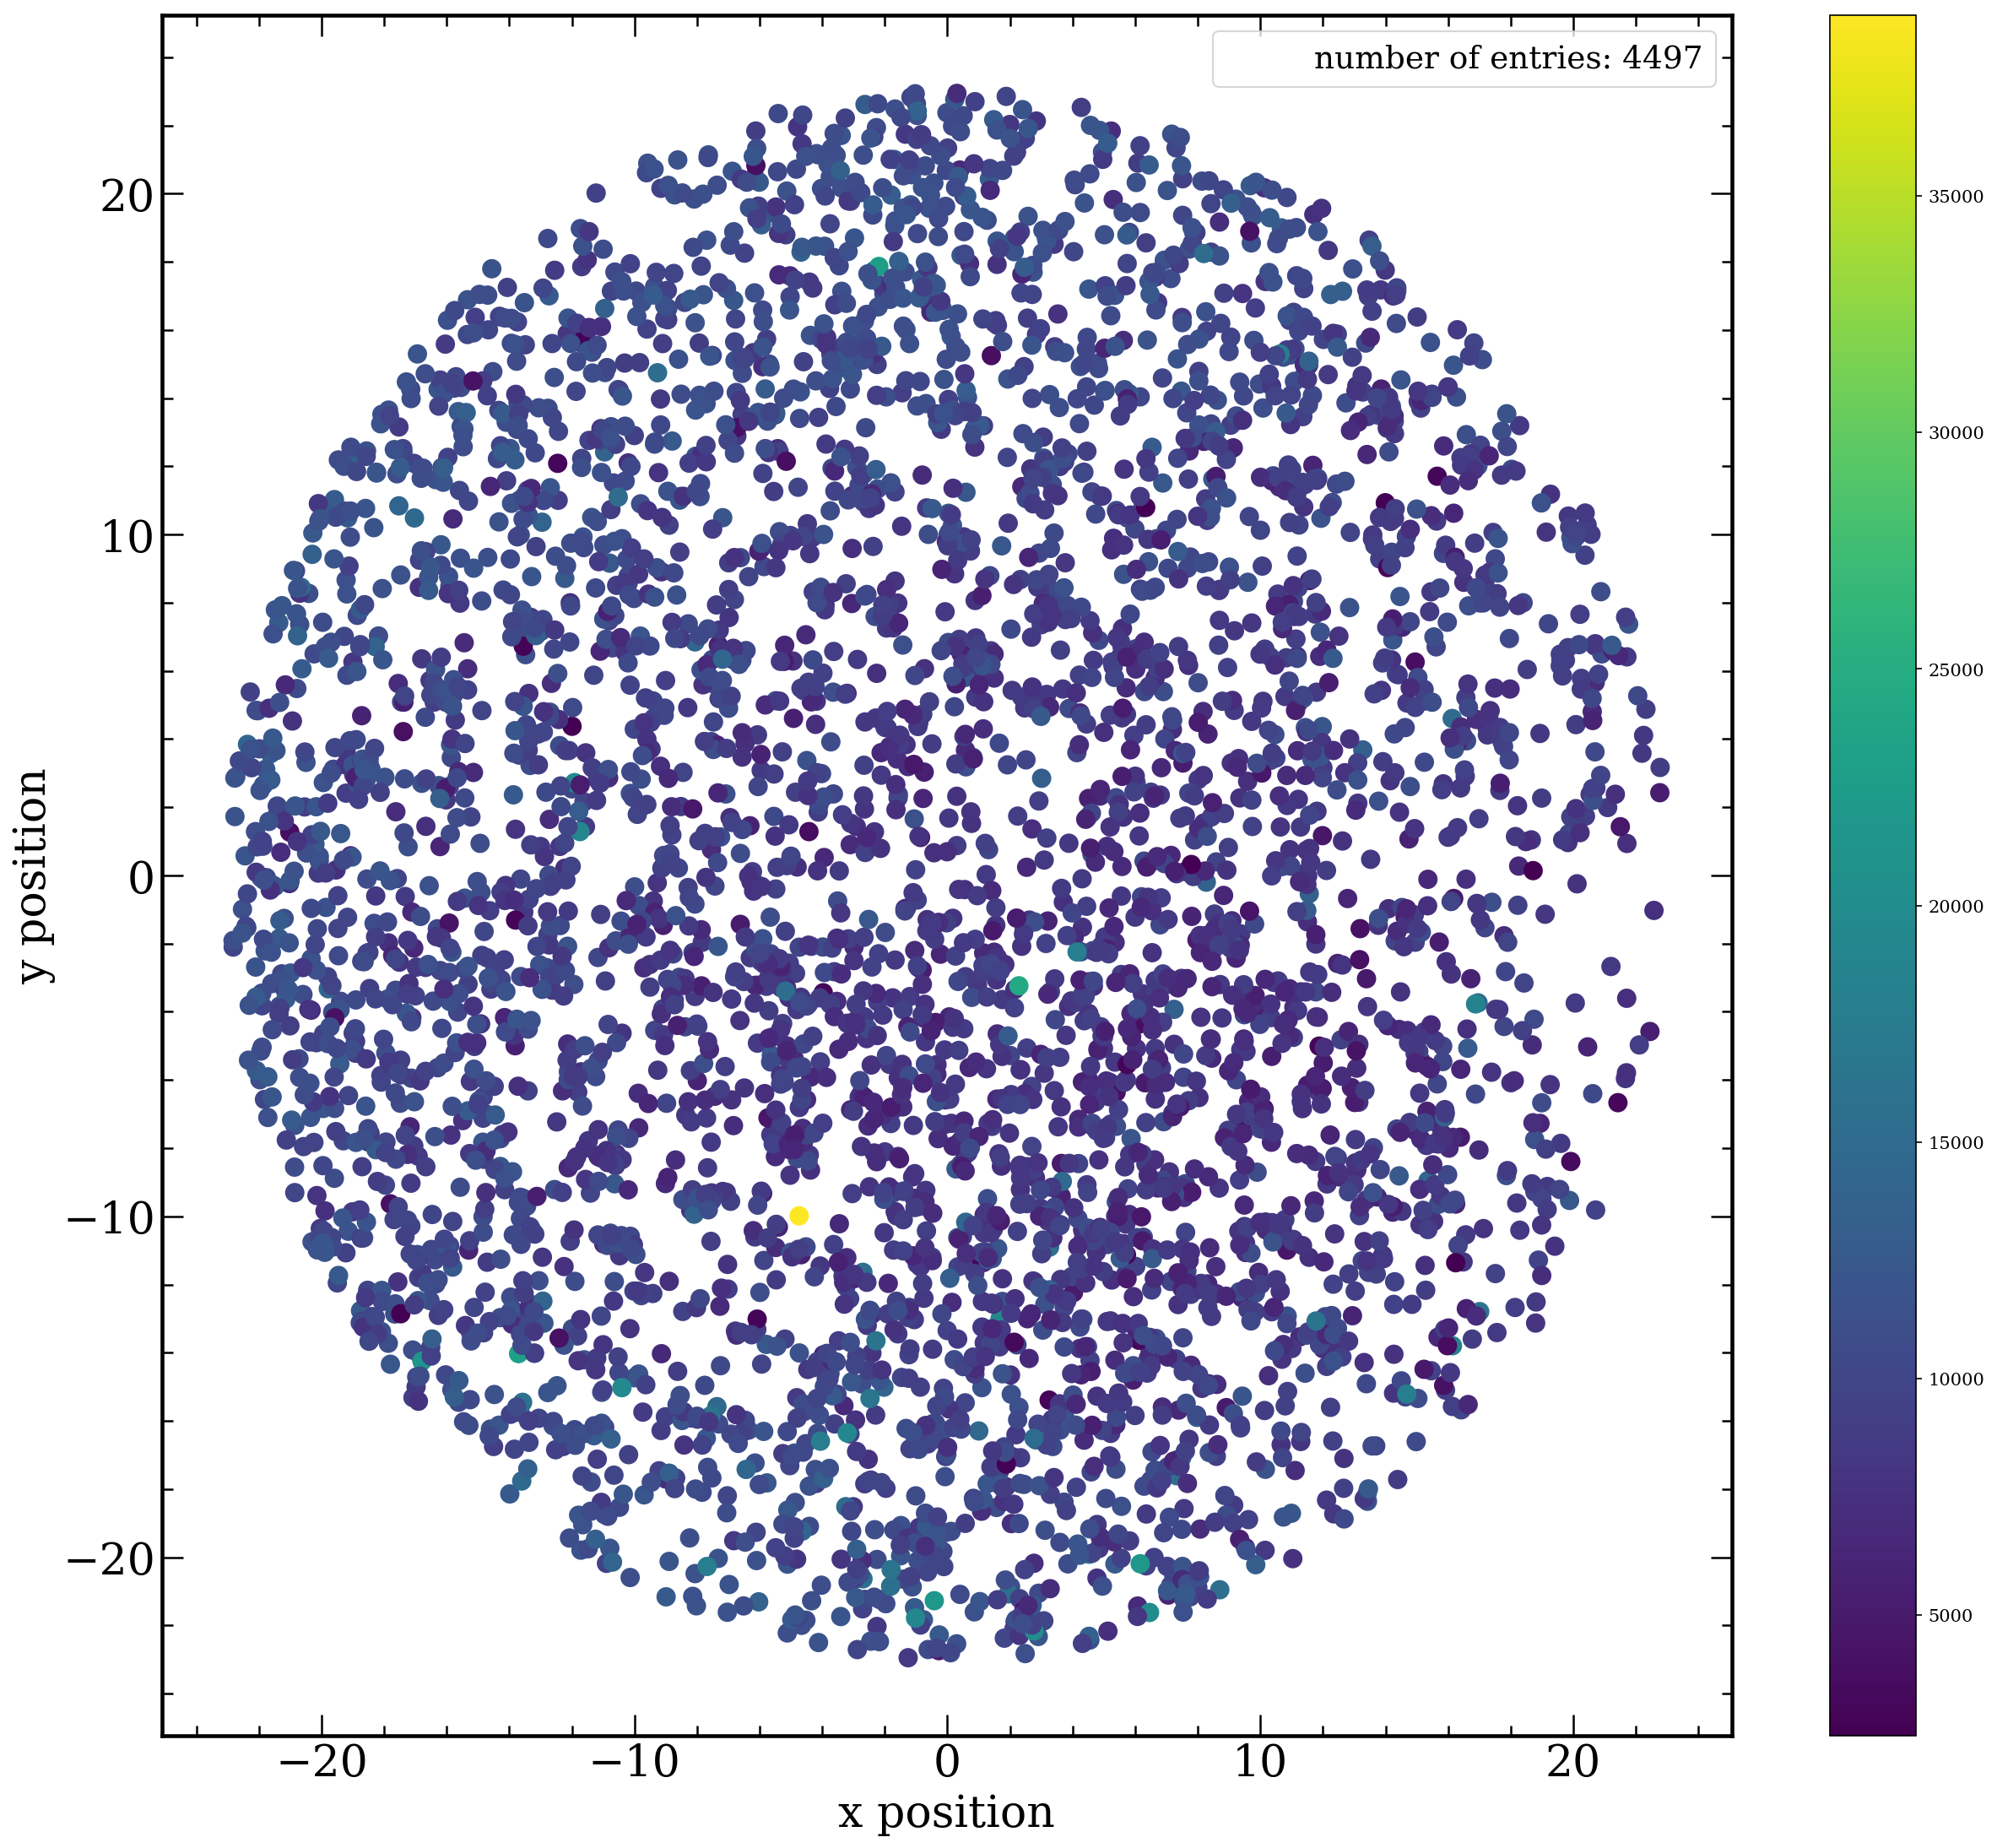

In [90]:
fig=plt.figure(figsize=(20, 18), dpi=150)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)
label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20
axes = plt.gca()
axes.tick_params(axis='both')
for axis in ['top', 'bottom', 'left', 'right']:
    axes.spines[axis].set_linewidth(2.2)
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)
bins_x = np.linspace(-35,35,80)
bins_y = np.linspace(-35,35,80)
sc = axes.scatter(x_cut, y_cut, c =cs2_cut, s=100)
cb = plt.colorbar(sc)
# cb.set_label('ly [$\\frac{pe}{keV}$]',labelpad=-55, y=1.05, rotation = 0, size = 20)
# cb.ax.tick_params(labelsize=20)
axes.set_xlabel('x position')
axes.set_ylabel('y position')
axes.plot([], [], ' ', label="number of entries: "+str(len(x_cut)))
#currentAxis = plt.gca()
#circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
#currentAxis.add_artist(circle)
axes.legend(prop={'size': 18})

plt.show()


# 4. Investigate electrostatic sagging

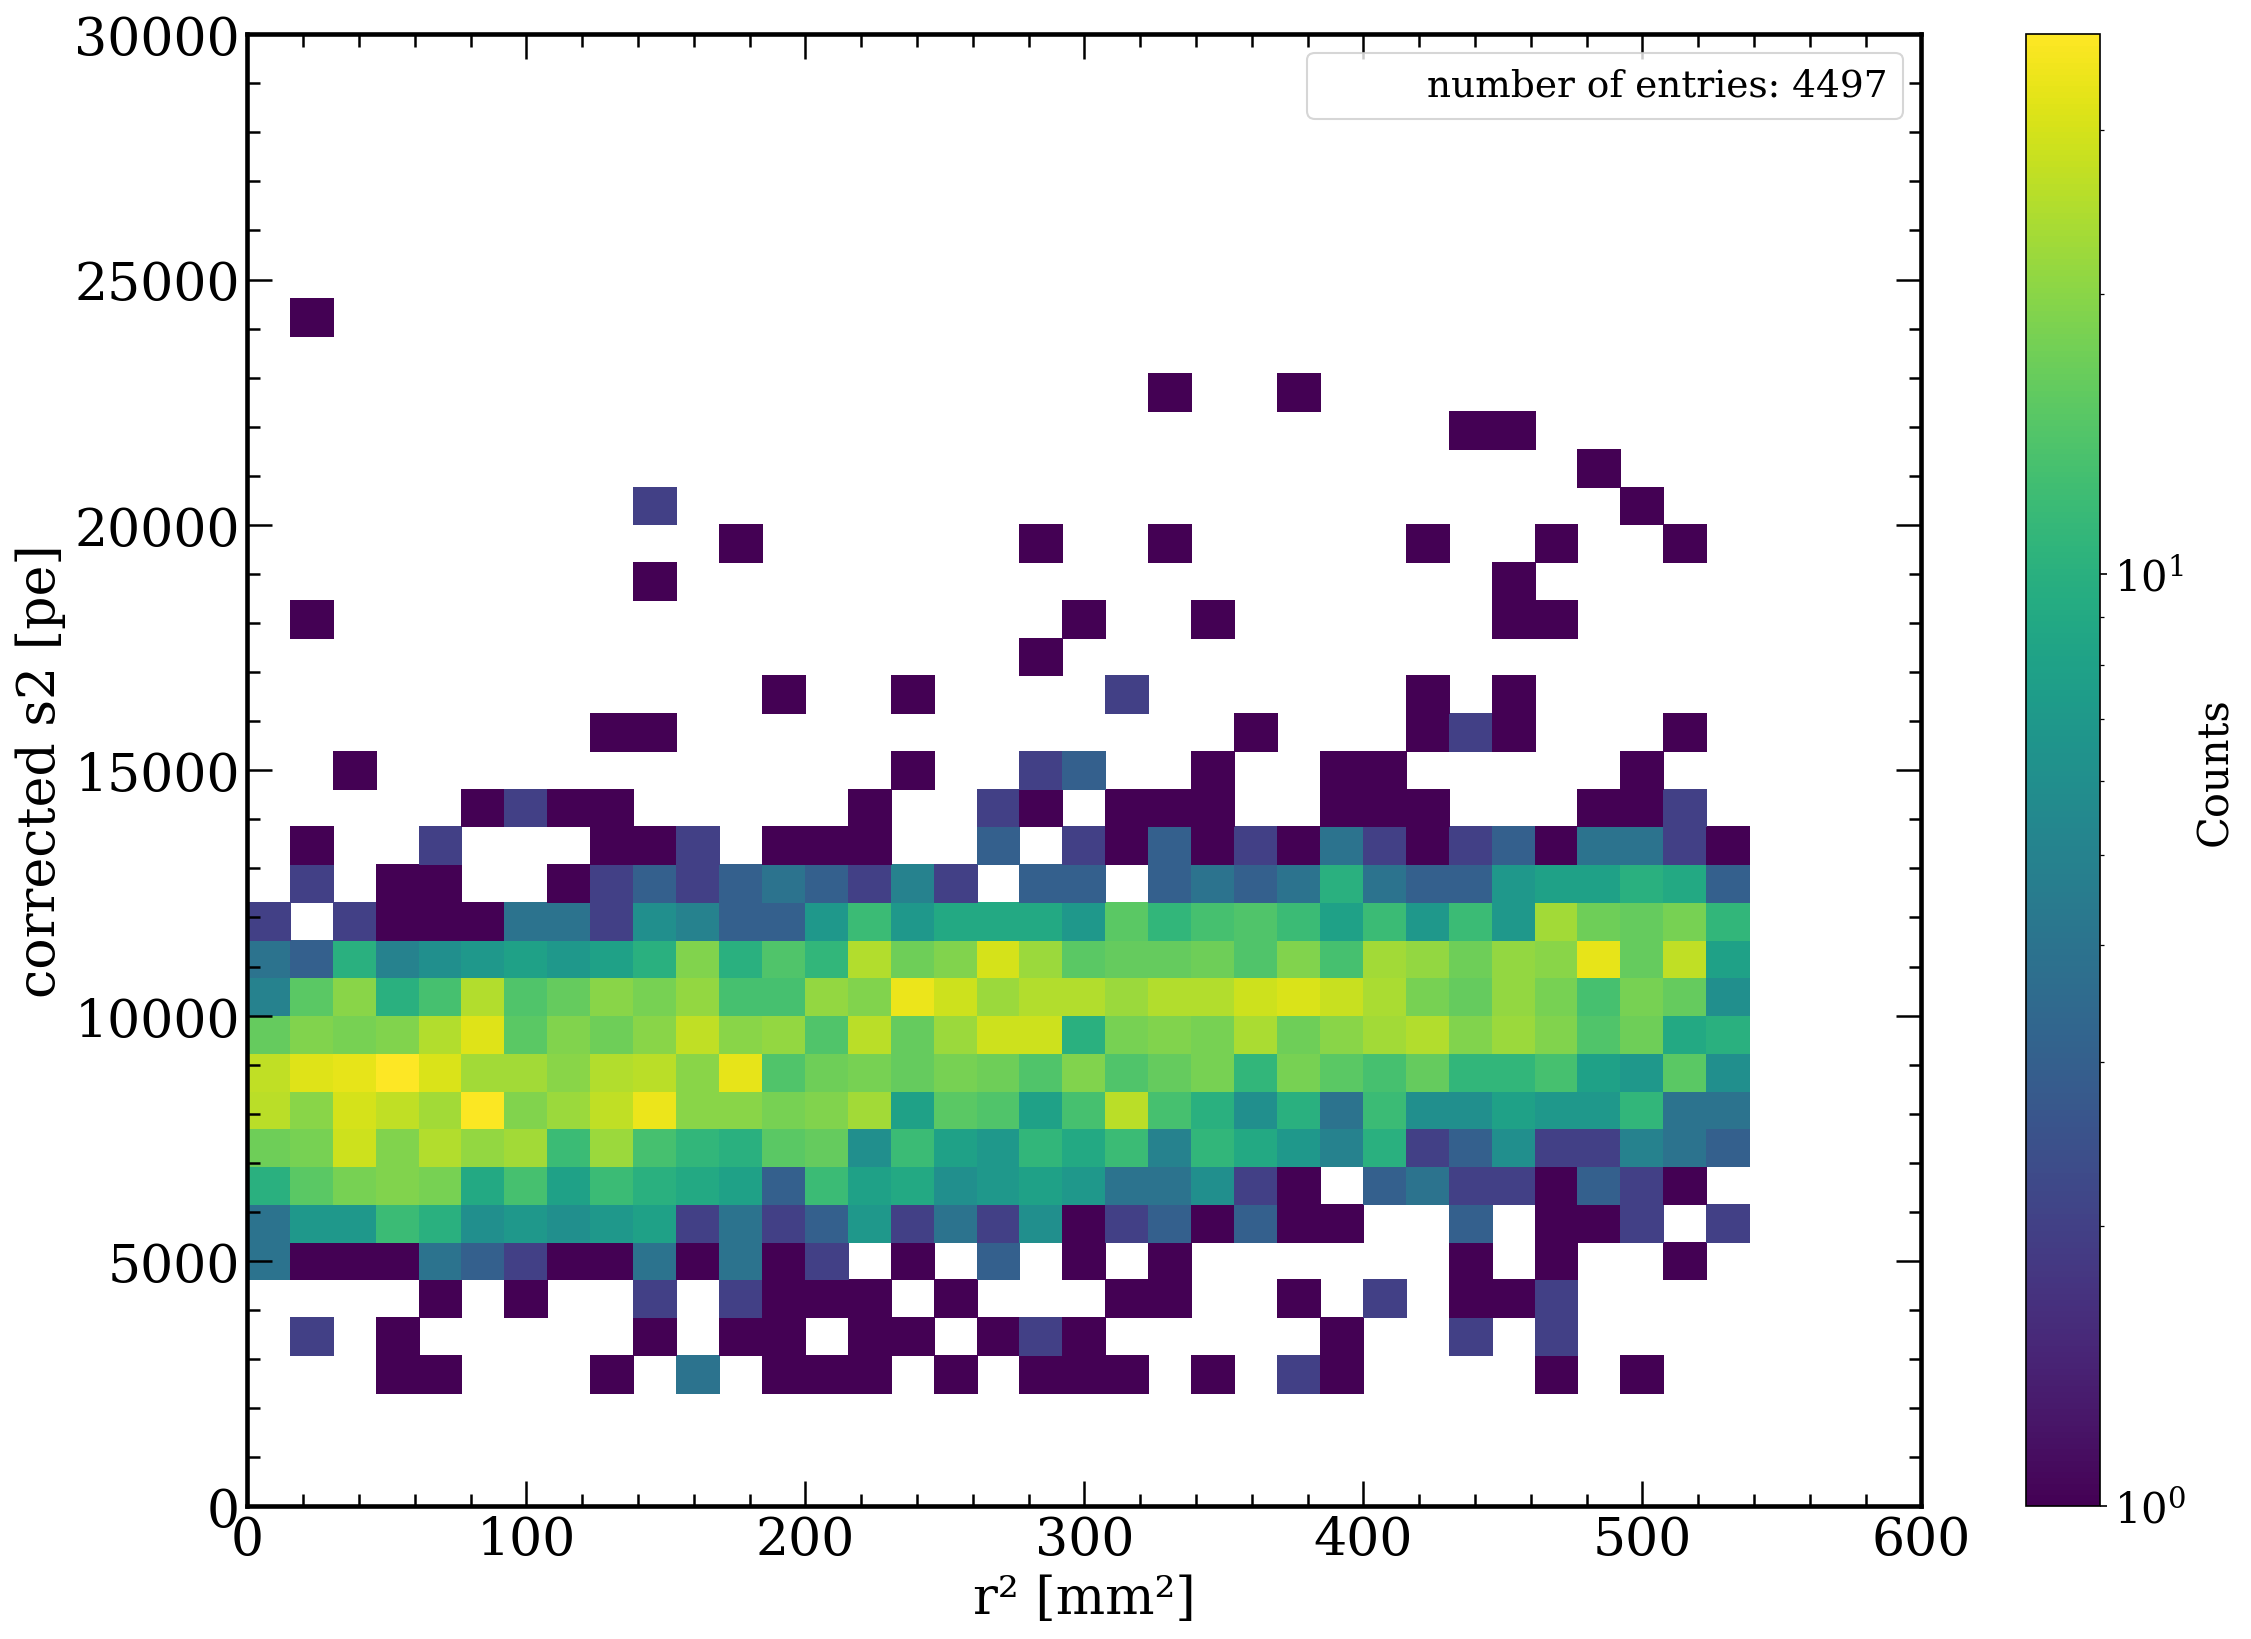

In [82]:
fig, axes = ps.styles()
r_2_cut = np.array(r_cut)**2

bins_x = np.linspace(0,600,40)
bins_y = np.linspace(0,30000,40)
counts, _, _ = np.histogram2d(r_2_cut,cs2_cut, bins=(bins_x, bins_y))
im = axes.pcolormesh(bins_x, bins_y, counts.T, norm=mpl.colors.LogNorm(), cmap = 'viridis')
cb = plt.colorbar(im, ax=axes, label='Counts')
cb.set_label('Counts',size=20)
cb.ax.tick_params(labelsize=20)
axes.plot([], [], ' ', label="number of entries: "+str(len(r_cut)))
axes.set_xlabel('r² [mm²]')
axes.set_ylabel('corrected s2 [pe]')
axes.legend(prop={'size': 18})
plt.show()

